In [52]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

np.random.seed(101)
sns.set_theme(style="darkgrid", color_codes=True)

import warnings
warnings.simplefilter("ignore")

%matplotlib inline


**Important:** \
To facilitate agile development and the task of exporting parts of the notebook to a script, only general imports are performed here, to contextualize the need to import other libraries to the specific chunk of code executed in each cell throughout the notebook

In [53]:
path = './input/forestfires.csv'

forestfire = pd.read_csv(path)    
forestfire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [54]:
forestfire.shape

(517, 13)

In [55]:
forestfire.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

## Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Target variable: Burned Area')

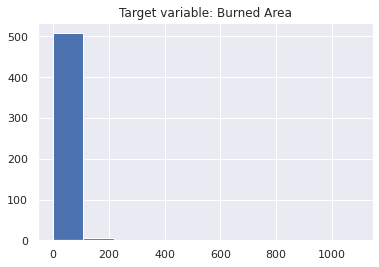

In [56]:
plt.hist(forestfire.area)
plt.title('Target variable: Burned Area')

Text(0.5, 1.0, 'Log transformation: Log(Area+1)')

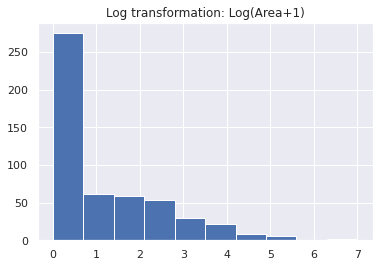

In [57]:
forestfire['arealog'] = np.log1p(forestfire.area)

plt.hist(forestfire.arealog)
plt.title('Log transformation: Log(Area+1)')

We shall use **'arealog' as the new target variable**. \
Furthermore, we are willing to frame the problem as a multiclass classification, trying to predict the severity or alarm level to be displayed with certain environmental conditions. \
**A logaritmic scale seems appropiate for this purpose**

In [58]:
print('Incidence of fires per month', 
        forestfire.month.value_counts(), 
        sep='\n')

Incidence of fires per month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64


In [59]:
print('Incidence of fires per day', 
        forestfire.day.value_counts(), 
        sep='\n')

Incidence of fires per day
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64


Quite a lot of seasonality is observed. \
One option would be creating dummy variables or applying one hot encoding to these variables. Another option would be to reframe the problem to a time series. \
But since we are trying to develop here a prediction model with potential to generalize to other geographic location and climates, we shall drop them instead

In [60]:
forestfire = forestfire.drop(
    ['month','day','area'], 
    axis=1
    )

In [61]:
forestfire.describe().T 

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00000,7.000000,9.00000
Y,517.0,4.299807,1.229900,2.0,4.0,4.00000,5.000000,9.00000
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60000,92.900000,96.20000
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30000,142.400000,291.30000
DC,517.0,547.940039,248.066192,7.9,437.7,664.20000,713.900000,860.60000
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40000,10.800000,56.10000
temp,517.0,18.889168,5.806625,2.2,15.5,19.30000,22.800000,33.30000
RH,517.0,44.288201,16.317469,15.0,33.0,42.00000,53.000000,100.00000
wind,517.0,4.017602,1.791653,0.4,2.7,4.00000,4.900000,9.40000
rain,517.0,0.021663,0.295959,0.0,0.0,0.00000,0.000000,6.40000


In [62]:
corr_matrix = forestfire.corr()

<AxesSubplot:>

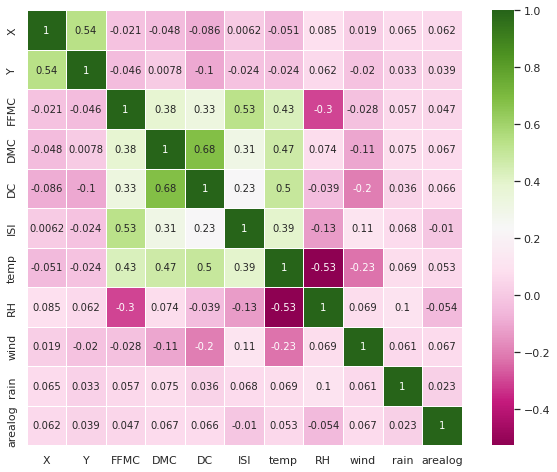

In [63]:
plt.subplots(figsize=(11, 8))
sns.heatmap(corr_matrix, 
    cmap='PiYG', annot=True,
    linewidth=1, linecolor='w', square=True)

Having eliminated any possible effects of autocorrelation due to temporal variables and seasonality, there seems to be very little correlation between the predictors and the target variable 'arealog' (implying no linear or direct cause-effect relationship) \
... which makes the problem more challeging

In [64]:
corr_matrix.arealog.sort_values(ascending=False)

arealog    1.000000
DMC        0.067153
wind       0.066973
DC         0.066360
X          0.061995
temp       0.053487
FFMC       0.046799
Y          0.038838
rain       0.023311
ISI       -0.010347
RH        -0.053662
Name: arealog, dtype: float64

FFMC, DMC, DC and ISI are aggregated values of the last 12 months. They are established by the FWI system to assess the potential damage of any fire. This exercise will allow us to learn about their prediction power. \
Temperature, relative humidity, wind and rain are on the other hand real time values

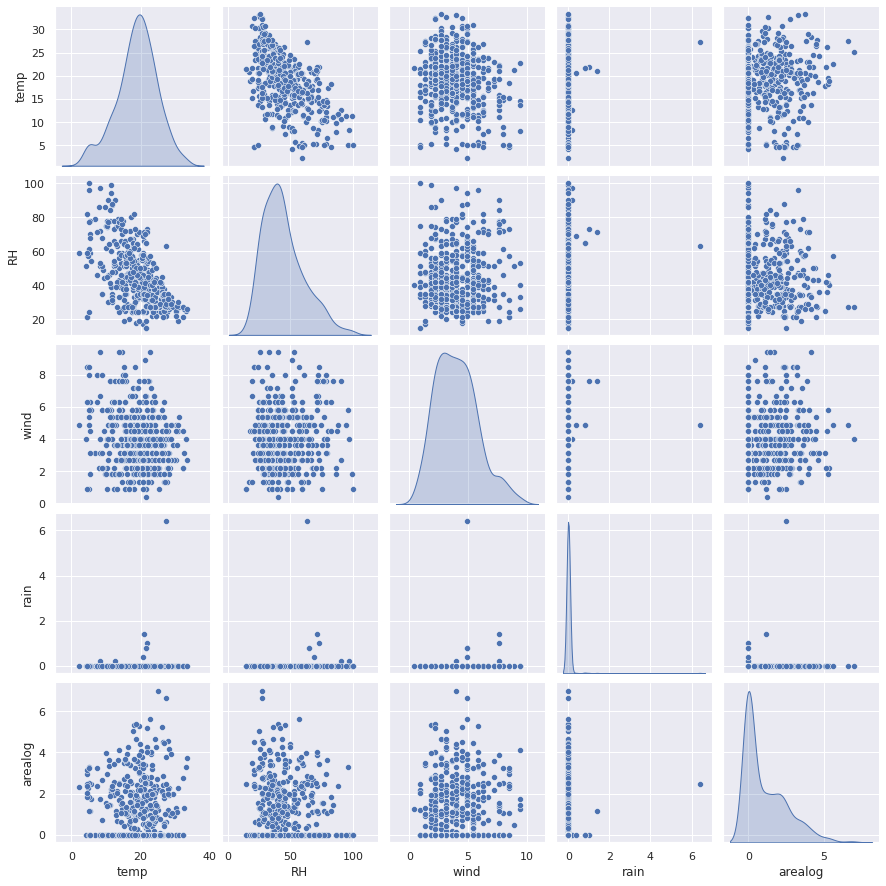

In [65]:
sns.pairplot(
    forestfire[['temp', 'RH', 'wind', 'rain', 'arealog']],
    diag_kind="kde"
    )
plt.show()

It is worth noting that rain is the worst predictor of all (almost irrelevant), because virtually all the days with rain register no fire

In [66]:
forestfire['risk_number'] = pd.cut(
    forestfire['arealog'], 
    bins=[0, 1, 2, 3, 8], 
    include_lowest=True, 
    labels=[
        '0-1: safe', 
        '1-2: minor risk', 
        '2-3: major risk', 
        '> 3: emergency']
)
forestfire.risk_number.value_counts()

0-1: safe          299
1-2: minor risk     84
2-3: major risk     74
> 3: emergency      60
Name: risk_number, dtype: int64

We will later use these "hazard levels" based on log scale 10 to evaluate the regression model output as **potential damage associated with specific weather conditions.** \
Apparently, with these 4 categories the dataset looks quite balanced: aprox. 58% of cases correspond to relatively safe conditions, and fire incidents are further distributed in 3 homogeneous groups

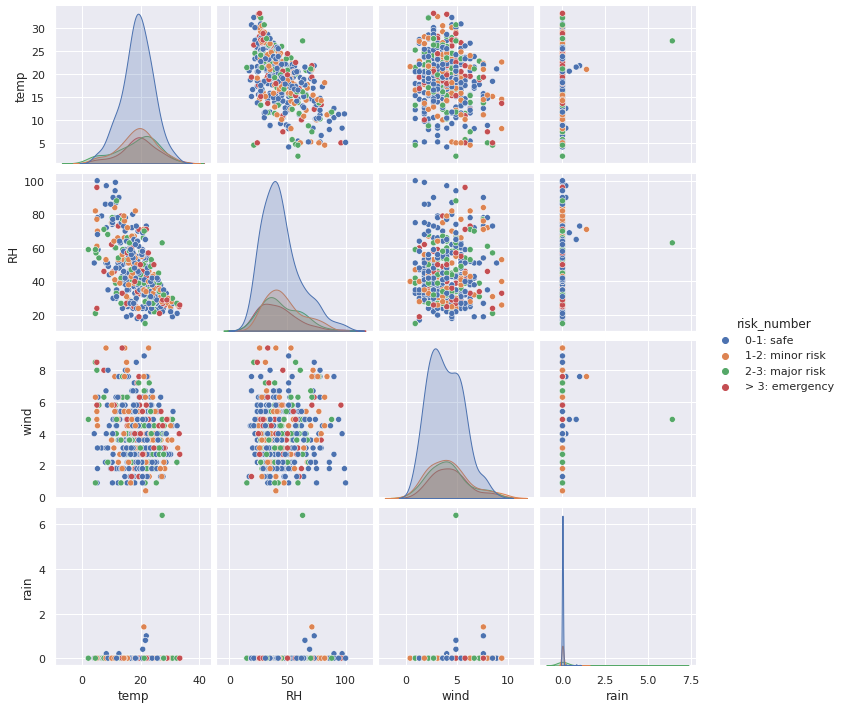

In [67]:
sns.pairplot(
    forestfire, 
    hue='risk_number', 
    vars = ['temp', 'RH', 'wind', 'rain'],
    diag_kind="kde"
    )
plt.show()

**It is apparently impossible to form groups abstracting patterns from this data.** \
Perhaps these data decontextualized from its specific geographic position lacks predictive value. We will later see when trying to obtain a regression model


In [68]:
forestfire.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'arealog', 'risk_number'],
      dtype='object')

In [69]:
y = forestfire['arealog'].to_numpy()
X = forestfire.drop(columns=['arealog', 'risk_number']).to_numpy()

In [70]:
y.shape

(517,)

In [71]:
X.shape

(517, 10)

Ordinary least squares (OLS) default regression by statsmodels.api \
(in order to get a **baseline model**)

In [72]:
baseline = sm.OLS(y,X).fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.403
Model:                            OLS   Adj. R-squared (uncentered):              0.391
Method:                 Least Squares   F-statistic:                              34.22
Date:                Sun, 23 Jan 2022   Prob (F-statistic):                    7.99e-51
Time:                        21:32:47   Log-Likelihood:                         -899.83
No. Observations:                 517   AIC:                                      1820.
Df Residuals:                     507   BIC:                                      1862.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0403      0.032      1.271      0.204      -0.022       0.103
x2             0.0156      0.059      0.264      0.792      -0.100       0.132
x3             0.0076      0.005      1.403      0.161      -0.003       0.018
x4             0.0012      0.001      0.853      0.394      -0.002       0.004
x5             0.0003      0.000      0.910      0.363      -0.000       0.001
x6            -0.0244      0.015     -1.579      0.115      -0.055       0.006
x7             0.0015      0.017      0.089      0.929      -0.031       0.034
x8            -0.0059      0.005     -1.303      0.193      -0.015       0.003
x9             0.0766      0.036      2.135      0.033       0.006       0.147
x10            0.0776      0.211      0.368      0.713      -0.337       0.492
==============================================================================
Omnibus:                       87.023   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.327
Skew:                           1.158   Prob(JB):                     1.36e-28
Kurtosis:                       3.773   Cond. No.                     2.14e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

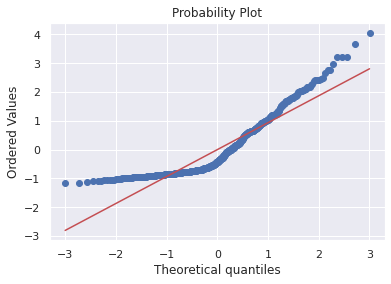

In [73]:
import scipy.stats as stats
import pylab

residuals = baseline.get_influence().resid_studentized_internal
stats.probplot(
    residuals, 
    dist="norm", 
    plot=pylab
)
plt.show()

Residuals are not distributed randomly along the line. \
Furthermore, **variability is not homogeneous (so-called homoscedasticity).** This would be the most important condition to validate any regression model. \
The lack of fitness implies no direct cause-effect can be established; perhaps there is too much noise, no linear effects or complex interactions among the predicting variables

In [74]:
# F-test for model significance
# F-ratio = (between-group variance) / (within-group variance)

fstatistic, pvalue = sm.stats.diagnostic.linear_rainbow(baseline)

print("F-ratio: {:.5f}".format(fstatistic))
print("P-value: {:.5f}".format(pvalue))

F-ratio: 1.06499
P-value: 0.30869


F-test for model significance: \
A statistical formalism to determine whether or not the model is irrelevant in explaining the variability in the data.

**Null hypothesis (H0)** : A model with no predictor variables (aka intercept-only or dummy model) fits the data as well as your regression model \
**Alternative hypothesis (HA)** : The regression model fits the data better



There is **no statistical evidence (low p-value) that the model is significant** \
(null hypothesis cannot be rejected)

1.16

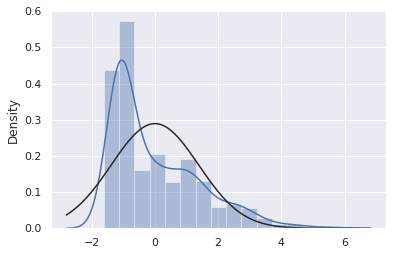

In [75]:
from scipy.stats import skew

sns.distplot(baseline.resid,fit=stats.norm)
round(skew(baseline.resid), 2)

A last piece of evidence, in the plot above we clearly see **residuals are not normally distributed**

## Model training

Since we have relatively few data, we will do a **simple split** developing a model that generalizes well for this type of problem, but assuming that once the model is implemented **it should be retrained with real-time data in order to fit the specific conditions** of the geographical region in which it is intended to put into service

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=101, 
    shuffle=True
    )


Important: \
We apply **shuffle=True** in order to avoid stationality due to weather seasons in the data

In [77]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Step 1: **screening options**

The authors of the original paper use two metrics to assess goodness of the fitted models:
- **Root mean square error (RMSE)**
- **Mean absolute error (MAE)**

Here we will use both; in principle the first to discriminate between models and the second, as suggested by the literature, to perform fine tuning. \
The coefficient of determination (R2) will allow us to better contextualize the results obtained \
(~ variation in the target variable that is predictable from the independent variable(s))

**R2 = 1 - (Residual sum of squares/Total sum of squares)**

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

baseline = LinearRegression()
baseline.fit(X_train,y_train)

y_pred = baseline.predict(X_test)
rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae=metrics.mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse.round(4))
print('MAE :', mae.round(4))
print('R2  :', abs(metrics.r2_score(y_test, y_pred).round(4)))

RMSE: 1.5339
MAE : 1.2609
R2  : 0.0224


To assess robustness, we will cross-validate with 10 folds.\
The standard deviation of the series serves here as an estimation of the **instability of the predictor** in the face of new data

In [79]:
from sklearn.model_selection import cross_val_score

scores0 = cross_val_score(
    baseline, 
    X_train, 
    y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=10)

print("RMSE per fold (10x):\n", abs(scores0).round(4))
print("Average RMSE:", abs(scores0).mean().round(4))
print("ST-DEV(RMSE) series:", abs(scores0).std().round(4))

RMSE per fold (10x):
 [2.2993 1.4852 1.2386 1.0597 1.253  1.2156 1.3921 1.4305 1.5582 1.3454]
Average RMSE: 1.4278
ST-DEV(RMSE) series: 0.3217


#### **DecisionTreeRegressor**

In [80]:
from sklearn.tree import DecisionTreeRegressor

model1 = DecisionTreeRegressor(random_state = 101)
model1.fit(X_train,y_train)

y_pred = model1.predict(X_test)
rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae=metrics.mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse.round(4))
print('MAE :', mae.round(4))
print('R2  :', abs(metrics.r2_score(y_test, y_pred).round(4)))

RMSE: 2.1096
MAE : 1.518
R2  : 0.9339


In [81]:
scores1 = cross_val_score(
    model1, 
    X_train, 
    y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=10)

print("RMSE per fold (10x):\n", abs(scores1).round(4))
print("Average RMSE:", abs(scores1).mean().round(4))
print("ST-DEV(RMSE) series:", abs(scores1).std().round(4))

RMSE per fold (10x):
 [2.2742 2.1722 1.8909 1.9801 1.8059 1.8282 2.3135 2.0779 2.0284 1.9784]
Average RMSE: 2.035
ST-DEV(RMSE) series: 0.1666


#### **RandomForestRegressor**

In [82]:
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(
#    bootstrap=True,
#    n_estimators=200,
#    max_features=1,
    random_state = 101
    )
model2.fit(X_train,y_train)

y_pred = model2.predict(X_test)
rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae=metrics.mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse.round(4))
print('MAE :', mae.round(4))
print('R2  :', abs(metrics.r2_score(y_test, y_pred).round(4)))

RMSE: 1.5468
MAE : 1.2435
R2  : 0.0397


In [83]:
scores2 = cross_val_score(
    model2, 
    X_train, 
    y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=10)

print("RMSE per fold (10x):\n", abs(scores2).round(4))
print("Average RMSE:", abs(scores2).mean().round(4))
print("ST-DEV(RMSE) series:", abs(scores2).std().round(4))

RMSE per fold (10x):
 [1.5888 1.6088 1.3271 1.0873 1.5158 1.2969 1.5263 1.4786 1.6276 1.421 ]
Average RMSE: 1.4478
ST-DEV(RMSE) series: 0.1606


#### **XGBRegressor**

In [84]:
from xgboost import XGBRegressor

model3 = XGBRegressor(random_state = 101)
model3.fit(X_train,y_train)

y_pred = model3.predict(X_test)
rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae=metrics.mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse.round(4))
print('MAE :', mae.round(4))
print('R2  :', abs(metrics.r2_score(y_test, y_pred).round(4)))

RMSE: 1.654
MAE : 1.2761
R2  : 0.1888


In [85]:
scores3 = cross_val_score(
    model3, 
    X_train, 
    y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=10)

print("RMSE per fold (10x):\n", abs(scores3).round(4))
print("Average RMSE:", abs(scores3).mean().round(4))
print("ST-DEV(RMSE) series:", abs(scores3).std().round(4))

RMSE per fold (10x):
 [1.7967 1.6854 1.4289 1.1897 1.828  1.4862 1.6741 1.6588 1.695  1.38  ]
Average RMSE: 1.5823
ST-DEV(RMSE) series: 0.1928


#### **KNeighborsRegressor**

In [86]:
from sklearn.neighbors import KNeighborsRegressor

model4 = KNeighborsRegressor(
#    n_neighbors=47
    )
model4.fit(X_train,y_train)

y_pred = model4.predict(X_test)
rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae=metrics.mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse.round(4))
print('MAE :', mae.round(4))
print('R2  :', abs(metrics.r2_score(y_test, y_pred).round(4)))

RMSE: 1.6999
MAE : 1.3344
R2  : 0.2557


In [87]:
scores4 = cross_val_score(
    model4, 
    X_train, 
    y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=10)

print("RMSE per fold (10x):\n", abs(scores4).round(4))
print("Average RMSE:", abs(scores4).mean().round(4))
print("ST-DEV(RMSE) series:", abs(scores4).std().round(4))

RMSE per fold (10x):
 [1.7214 1.7724 1.3923 1.0064 1.4588 1.3431 1.4357 1.6172 1.7443 1.411 ]
Average RMSE: 1.4903
ST-DEV(RMSE) series: 0.2212


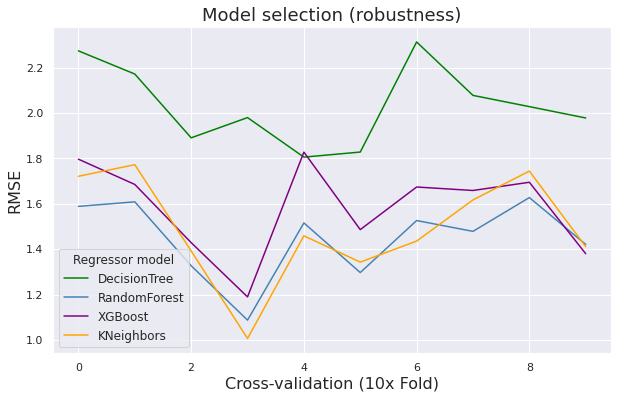

In [88]:
plt.subplots(figsize=(10, 6))
plt.plot(abs(scores1), label='DecisionTree', color='green')
plt.plot(abs(scores2), label='RandomForest', color='steelblue')
plt.plot(abs(scores3), label='XGBoost', color='purple')
plt.plot(abs(scores4), label='KNeighbors', color='orange')
plt.legend(title='Regressor model', fontsize=12)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('Cross-validation (10x Fold)', fontsize=16)
plt.title('Model selection (robustness)', fontsize=18)
plt.show()

We select **KNeighborsRegressor** for stability reasons. \
With equal benefits, it is also a significantly lighter model, which should prevail considering that we want it to deploy software

**Lessons learned:** \
The fact that KNeighbors is performing at the same level than quite complex tree-based models seems to suggest that there is an underlying structure in the data that cannot be safely modeled because the dataset has too much noise (or not enough data for this purpose). \
Noise can be caused by important factors that remain hidden. For example, can some fires be caused by humans and not created by environmental conditions?

### **Step 2**: optimization

We apply cv=3 here trying to prevent overfitting \
(from the graph above seems the optimum in the model training process).

**All models considered above are very prone to overfitting**

In [89]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "n_neighbors": range(1, 50), 
    "weights": ['uniform', 'distance']
    }
gridsearch = GridSearchCV(
    KNeighborsRegressor(), 
    parameters,
    cv=3, 
    scoring='neg_root_mean_squared_error'
    )
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [90]:
gridsearch.best_params_

{'n_neighbors': 43, 'weights': 'uniform'}

We validate **KNeighborsRegressor() as the best option**, but as an appendix we will use RandomForestRegressor() to evaluate and obtain information about the importance of features (it may be useful in the future for feature engineering)


**All things being equal, one should always choose the simplest model.** \
I consider that it is not possible to advance further in the analysis without expert knowledge of the subject allowing to filter and to engineer new predictive variables from the original data

In [91]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "bootstrap": [False,True],
    "n_estimators": [100,150,200,300], 
    "max_features": [1,2,4,8]
    }
gridsearch = GridSearchCV(
    RandomForestRegressor(), 
    parameters,
    cv=3, 
    scoring='neg_root_mean_squared_error'
    )
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [False, True],
                         'max_features': [1, 2, 4, 8],
                         'n_estimators': [100, 150, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [92]:
gridsearch.best_params_

{'bootstrap': True, 'max_features': 1, 'n_estimators': 200}

Text(0.5, 0, 'Feature Importance')

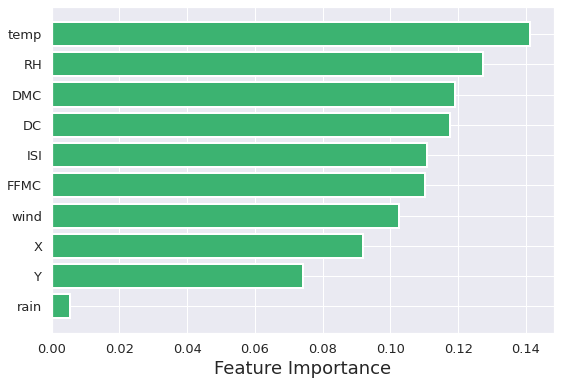

In [93]:
sorted_feature_importance = gridsearch.best_estimator_.feature_importances_.argsort()

plt.figure(figsize=(9, 6))
plt.barh(
        np.array(
                list(forestfire.drop(columns=['arealog', 'risk_number']))
                )[sorted_feature_importance], 
        np.array(
                gridsearch.best_estimator_.feature_importances_
                )[sorted_feature_importance], 
        color='mediumseagreen',
        edgecolor='white', 
        linewidth=2
        )
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Feature Importance", fontsize=18)

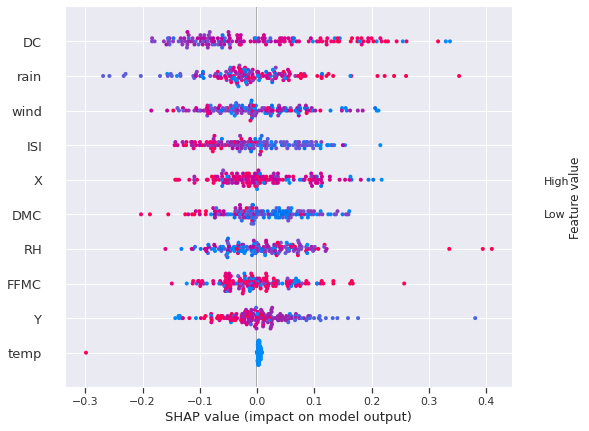

In [94]:
import shap

explainer = shap.TreeExplainer(gridsearch.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names = np.array(
                list(forestfire.drop(columns=['arealog', 'risk_number']))
                )[sorted_feature_importance],
    plot_size=(10, 7)
    )